# Path Planning On a Grid :: A* Algorithm (with Cons/Incons Heuristic)

<center><img src="./img/1.png"/></center>

In this lab, we will consider the problem of finding the shortest path on a graph with a special structure, widely used in robotics and computer games — a grid. The grid consists of both free and blocked cells, and an agent can move from one free cell to another. The connectivity of the grid may vary; for example, a grid might be 4-connected when only cardinal moves (N, E, W, S) are allowed, or 8-connected when diagonal moves are allowed as well.

**In this lab, we assume that the grid is 4-connected**, meaning that only moves into the cardinal directions (N, E, W, S) are allowed. The cost of each move between two neighboring cells, represented as $v$ and $v'$, is uniform, with $cost(v, v') = 1$.

We will explore the seminal `A*` algorithm for finding the shortest path on a grid.

Our exploration will involve two heuristic functions: Manhattan (which is admissible and consistent) and "noisy Manhattan" (which is admissible but inconsistent). We'll code two versions of `A*`: one with node re-opening and one without. Notably, the version without node re-opening may not solve the problem accurately when using the inconsistent heuristic.

Our `A*` implementation will draw heavily from the `Dijkstra` algorithm, which we covered in a previous lab.

Your task is to complete the missing code fragments as per the provided prompts and execute every cell in this notebook. All tests should pass successfully.

Let's get started!


In [1]:
from heapq import heappop, heappush
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

%matplotlib inline

## Grid Map Representation

In [2]:
from utils.map import Map
from utils.utils import convert_string_to_cells

In [3]:
from utils.utils import compute_cost

Computes the cost of a transition from cell `(i1, j1)` to cell `(i2, j2)`. In the case of a 4-connected grid, the cost is always equal to 1. Consequently, the cost of each path is an integer.

However, please note that if the grid's connectivity exceeds 4, the cost of a transition may vary and may become fractional or even arbitrary (e.g., $\sqrt{2}$ for diagonal moves).

Recall that in this lab, we assume a 4-connected grid, meaning that only cardinal moves (up, down, left, right) are allowed, and as a result, all costs are integers.


In [4]:
help(compute_cost)

Help on function compute_cost in module utils.utils:

compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move (only cardinal moves are supported).



## Search Node

A Search node is a fundamental concept in heuristic search algorithms. It encapsulates data about the state of the problem (e.g., the position of a robot or agent on a grid) and the information needed to construct a search tree, including g-values, h-values, f-values, and a backpointer to its predecessor.


In [5]:
from utils.node import BaseNode

class Node(BaseNode):
    def __lt__(self, other):
        """
        Compares the keys of two nodes, which is needed for sorting/extracting the best element from OPEN.
        """
        return self.f < other.f

BaseNode has an implementation of the `__hash__`, `__lt__` and `__eq__` methods, so you can use nodes as dict keys.

In [6]:
help(BaseNode)

Help on class BaseNode in module utils.node:

class BaseNode(builtins.object)
 |  BaseNode(
 |      i: int,
 |      j: int,
 |      g: Union[float, int] = 0,
 |      h: Union[float, int] = 0,
 |      f: Union[float, int, NoneType] = None,
 |      parent: Optional[ForwardRef('BaseNode')] = None
 |  )
 |
 |  Represents a search node.
 |
 |  Attributes
 |  ----------
 |  i : int
 |      Row coordinate of the corresponding grid element.
 |  j : int
 |      Column coordinate of the corresponding grid element.
 |  g : float | int
 |      g-value of the node.
 |  h : float | int
 |      h-value of the node (always 0 for Dijkstra).
 |  f : float | int
 |      f-value of the node (always equal to g-value for Dijkstra).
 |  parent : Node
 |      Pointer to the parent node.
 |
 |  Methods defined here:
 |
 |  __eq__(self, other)
 |      Checks if two search nodes are the same, which is needed
 |      to detect duplicates in the search tree.
 |
 |  __hash__(self)
 |      Makes the Node object hash

## Visualization

In [7]:
from utils.utils import draw

Example of the visualization

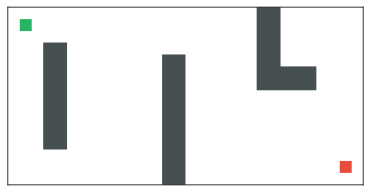

In [8]:
height = 15
width = 30
map_str = """
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
"""
cells = convert_string_to_cells(map_str)

test_map = Map(cells)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

## Implementing the Search Tree (i.e., OPEN and CLOSED)
An efficient implementation of the search tree (`OPEN` and `CLOSED`) is crucial for any search algorithm. You should utilize the efficient search tree implementation you developed in the previous lab.

In [9]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return not self._open

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        # Add node without checking for duplicates; they are handled lazily later. (in get_best_node)
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while self._open:
            node = heappop(self._open)
            if not self.was_expanded(node):
                return node
            else:
                self._enc_open_duplicates += 1
        return None
                

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

## Validating the Results

When you finish implementing search algorithms, you'll naturally want to test them. The following functions will help you in doing just that.

`simple_test` runs the pathfinding algorithm on a single, straightforward instance, while `massive_test` executes it on a series of more involved instances. Both tests operate under the assumption that the search function follows the pattern below:

```
search(task_map, start.i, start.j, goal.i, goal.j, *optional arguments*) -> (path_found, last_state, steps, search_tree_size, open, closed)
```

These automated tests anticipate that the search function, which is passed as an input, adheres to the following structure:

- `task_map` is the grid
- `start.i, start.j` are the  $(i, j)$ coordinates of the starting cell
- `goal.i, goal.j` are the $(i, j)$ coordinates of the goal cell
- `*optional arguments*` represent additional parameters of the search function, passed with *args. For instance, the heuristic function.
- `path_found` is `True` if a path was found and `False` otherwise
- `last_state` denotes the last state of the path. It returns `None` if a path was not found
- `steps` provides the number of search steps taken
- `search_tree_size` represents the number of nodes that make up the search tree at the final iteration of the algorithm, which equates to the size of the resultant search tree.
- `open` is an iterable collection of the nodes that form the search frontier (OPEN nodes)
- `closed` is an iterable collection of the expanded nodes (CLOSED)


In [10]:
from tests.lab_test import simple_test, simple_test_not_found, massive_test

## A* Algorithm Without Reexpansions

The primary component of the `A*` algorithm is the heuristic function.

Ideally, this function should be admissible (it never overestimates the true cost to the goal) and consistent (satisfies the triangle inequality). The Manhattan distance serves as an admissible and consistent heuristic for 4-connected grids. Therefore, if we integrate it into the `Dijkstra` search loop from the previous lab, we'll obtain the `A*` algorithm.

Let's proceed!


In [11]:
def manhattan_distance(i1: int, j1: int, i2: int, j2: int) -> int:
    """
    Computes the Manhattan distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Manhattan distance between the two cells.
    """
    return abs(i1 - i2) + abs(j1 - j2)

The input for the `A*` algorithm implementation is the same as for `Dijkstra`:

The input is:
- map representation
- start/goal cells
- heuristic function $^*$
- a reference to the implementation of the SearchTree

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)
- OPEN and CLOSED (as iterable collections of nodes) for further visualization purposes


PS: You might also want to display, at the final iteration, the number of OPEN duplicates encountered during the search, as shown below:

```print("During the search, the following number of OPEN duplicates was encountered: ", ast.number_of_open_duplicates) ```


In [12]:
def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    def get_heuristic(node_i, node_j):
        return heuristic_func(node_i, node_j, goal_i, goal_j)
        
    ast = search_tree()
    steps = 0
    start_node = Node(start_i, start_j, g=0, h=get_heuristic(start_i, start_j))
    goal_node = Node(goal_i, goal_j)
    
    ast.add_to_open(start_node)

    while node := ast.get_best_node_from_open():
        steps += 1
        ast.add_to_closed(node)
        if node == goal_node:
            print("During the search, the following number of OPEN duplicates was encountered: ", ast.number_of_open_duplicates)
            return True, node, steps, len(ast), ast.opened, ast.expanded
        for i, j in task_map.get_neighbors(node.i, node.j):
            neighbor = Node(i, j, g=node.g + compute_cost(node.i, node.j, i, j),
                            h=get_heuristic(i, j), parent=node)
            if not ast.was_expanded(neighbor):
                ast.add_to_open(neighbor)

    print("During the search, the following number of OPEN duplicates was encountered: ", ast.number_of_open_duplicates)
    return False, None, steps, len(ast), ast.opened, ast.expanded

During the search, the following number of OPEN duplicates was encountered:  40


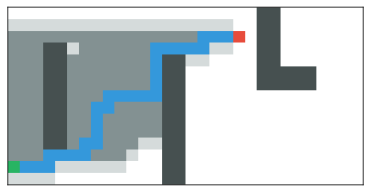

Path found! Length: 30. Search tree size: 228. Number of steps: 134. Correct: True
CPU times: user 20.4 ms, sys: 24 μs, total: 20.4 ms
Wall time: 19.5 ms


In [13]:
"""
The code should execute correctly if your A* implementation is accurate.
Experiment with the test instance number (the 2nd argument) to execute the search algorithm on various start/goal pairs.
"""
%time res = simple_test(astar, 1, manhattan_distance, SearchTreePQD)

During the search, the following number of OPEN duplicates was encountered:  206


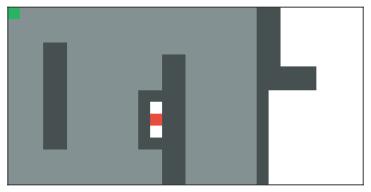

Path not found! Search tree size: 265. Number of steps: 265. Correct: True
CPU times: user 19.4 ms, sys: 118 μs, total: 19.5 ms
Wall time: 18.5 ms


In [14]:
"""
The code will execute correctly if the A* implementation properly handles cases where a path doesn't exist.
"""
%time res = simple_test_not_found(astar, 1, manhattan_distance, SearchTreePQD)

In [15]:
"""
Test the efficient implementation of A* on the complete set of large instances (9 in total). 
Every test should execute correctly.

On my modern laptop (2022 Asus, Intel iCore7, 16Gb RAM, SSD) the entire test finishes 
in about 3 seconds, which is about half the time taken by Dijkstra's algorithm in the previous lab.
"""

%time res = a_star_stat = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQD)

During the search, the following number of OPEN duplicates was encountered:  153
Task: #0. Path found! Length: 64. Search tree size: 808. Number of steps: 441. Correct: True
During the search, the following number of OPEN duplicates was encountered:  2997
Task: #1. Path found! Length: 197. Search tree size: 3771. Number of steps: 3532. Correct: True
During the search, the following number of OPEN duplicates was encountered:  8312
Task: #2. Path found! Length: 462. Search tree size: 26538. Number of steps: 17344. Correct: True
During the search, the following number of OPEN duplicates was encountered:  25019
Task: #3. Path found! Length: 498. Search tree size: 27884. Number of steps: 27371. Correct: True
During the search, the following number of OPEN duplicates was encountered:  21509
Task: #4. Path found! Length: 479. Search tree size: 24928. Number of steps: 23723. Correct: True
During the search, the following number of OPEN duplicates was encountered:  3238
Task: #5. Path found! Le

## Inconsistent Heuristic Function

Using an admissible but inconsistent heuristic can lead to incorrect behavior if you don't implement re-opening or re-expansion in `A*` (as we've done up to this point). Let's observe this.


In [16]:
def inconsistent_heuristic(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    An inconsistent heuristic function tailored for the simple_test map.
    This heuristic is based on the Manhattan distance scaled by a coefficient
    ranging between 0 and 1. Although this range ensures the function doesn't
    overestimate the actual distance between cells, it introduces inconsistency.

    Parameters
    ----------
    i1, j1 : int, int
        Coordinates (i, j) of the first cell on the grid.
    i2, j2 : int, int
        Coordinates (i, j) of the second cell on the grid.

    Returns
    -------
    int | float
        Scaled Manhattan distance between the two cells.
    """
    coef = [[0.32831655869667997, 0.02602781916714625, 0.32602955554375024, 0.06234916377268629, 0.35295444407424986, 0.4399763742097014, 0.46962919934270825, 0.16144646916333383, 0.04178119522641788, 0.3615984917894237, 0.1663930560924083, 0.1556095515496247, 0.023184930929364966, 0.2417350062696204, 0.14690725879414124, 0.020766506492569392, 0.006869319632844428, 0.3824707325836774, 0.3912138018969597, 0.201089314826286, 0.2884529835910057, 0.4795063591225301, 0.10333745819385776, 0.33834740384881046, 0.08447318037398205, 0.010754818060922267, 0.23611557024543672, 0.3629237250718168, 0.3678390854556626, 0.0006988268075135973], [0.17081730580243898, 0.42815946938275257, 0.024739567784460792, 0.2384247988728579, 0.4480895478056663, 0.43049105235702034, 0.3649923418701008, 0.08565497107344322, 0.4069843090234916, 0.32498662639563125, 0.2826508716412064, 0.1973909468425717, 0.4125632682759354, 0.29608357889521686, 0.04662324665294576, 0.32915442809479756, 0.08864327609387218, 0.4643067499890007, 0.3963962928888365, 0.0402016795594885, 0.2954060455404461, 0.38728059734093084, 0.19527308273361277, 0.3170835313741325, 0.3294472639012368, 0.302480192507245, 0.23827669438631033, 0.11079177021531394, 0.43438329910834717, 0.1465810756285223], [0.27794966579449815, 0.4958689976703051, 0.2367219131177683, 0.11742295670949221, 0.36177711351980735, 0.20951533058916783, 0.3063171220477524, 0.2728786620098217, 0.2959417227081334, 0.4209509633145379, 0.32077674238174947, 0.3532802742140129, 0.10159841447119167, 0.2625386536587789, 0.23272086429640437, 0.4119533662959103, 0.46798257469700083, 0.43826446882497194, 0.19412482734352465, 0.41570757993008334, 0.09194411485967935, 0.3374939455246143, 0.48950601103738256, 0.045810930194507216, 0.4681125020725993, 0.44697056880494346, 0.2974354458736584, 0.09661345183840903, 0.10179352117821233, 0.4984785204236554], [0.31651770176123994, 0.1993533617539145, 0.05498519883408326, 0.407507877609872, 0.20989800681581555, 0.23189729215295218, 0.47632912929283583, 0.44082813541052335, 0.37641111507987496, 0.3705325659565917, 0.27114709146390303, 0.2749722526417302, 0.17510400455600839, 0.24928453580259324, 0.26706843358187277, 0.20003119594515434, 0.48517351349738025, 0.358737443887516, 0.014499586935358744, 0.3695458096843226, 0.4139350643060239, 0.2637524793563651, 0.4333072493320588, 0.3866231497861453, 0.11568118966984908, 0.3866545361237745, 0.37255358968718705, 0.4536093231053632, 0.028298598616680992, 0.3843631281995794], [0.022936654540356094, 0.25692869680419306, 0.19114439827311597, 0.003914578307714578, 0.39772983606753926, 0.48127846041963485, 0.15484631395861503, 0.17908081898759592, 0.3090343519006113, 0.10462195950165115, 0.25317932866238774, 0.2009237282348788, 0.09359760036914322, 0.40364807856529455, 0.055891331785010545, 0.16337863324659613, 0.2691732384510364, 0.07486676107970769, 0.2314626630913364, 0.12306319045683534, 0.11356274675838057, 0.4599953194126375, 0.47460828131193905, 0.005834864826164188, 0.23612309430392764, 0.24485991819861713, 0.3434512516138732, 0.0016997052470916763, 0.4652005711931813, 0.10897558145101721], [0.4177181343966487, 0.09069818058411377, 0.2583378454221766, 0.2926980136879932, 0.26099645390826415, 0.18663359178918487, 0.16494752746012747, 0.3045066233089356, 0.030327171547539444, 0.24211821728616623, 0.21020550645343966, 0.3254991411698671, 0.04408967134538244, 0.18516527405991012, 0.226869664228824, 0.35029312220233516, 0.48700545978262755, 0.03419912948567566, 0.024283669463694313, 0.47335552232710487, 0.42404061979262847, 0.33043653199901163, 0.2035393825503235, 0.14279930595010976, 0.41988656885759507, 0.41249205988560517, 0.2862977326301444, 0.09366895332179775, 0.45524177915388536, 0.3173102222994394], [0.3479789803766766, 0.12562823926040556, 0.0721693670613146, 0.20546695912853757, 0.307432280661857, 0.15892258220830824, 0.3307928002878911, 0.4282389396286852, 0.31895994328404403, 0.015396070429757436, 0.41000311890122926, 0.21378824993375084, 0.008321262258760398, 0.4013416238710389, 0.11679565203646447, 0.39068214734907575, 0.02756563930087408, 0.0864279961796352, 0.06269745872485477, 0.44744087209088734, 0.08554027053671065, 0.25808842487838324, 0.3792373276058973, 0.26592827742194886, 0.13573466401440826, 0.4221104642788447, 0.06931890321196982, 0.4811769460605059, 0.07160913132384294, 0.2209815674928729], [0.047394725493421, 0.3254532739454676, 0.4889474568782018, 0.4884912459734134, 0.08899137271945917, 0.0775187529515095, 0.036745730507082686, 0.46210733564619816, 0.46448504074512464, 0.27123073573140677, 0.4553565473284872, 0.37035303634205086, 0.4934678606962635, 0.019661386910363066, 0.17099346676189248, 0.4392004470387358, 0.3464041754911792, 0.40975379020666525, 0.0745008466846444, 0.059201027939790096, 0.30856935195187274, 0.10104120745569212, 0.05457760583206317, 0.3965116846153794, 0.05947587542297933, 0.05997362484679519, 0.21266215363724134, 0.3253803194397574, 0.09565183795743193, 0.05053070702793], [0.21016734098859463, 0.20770958451528826, 0.43514843066138503, 0.493903227225951, 0.020299587679046216, 0.24146914435409378, 0.2181407280720607, 0.1917221461239899, 0.25323225857425924, 0.29383437486496217, 0.35093631239493345, 0.2835156184377993, 0.4751285589586037, 0.23135718860454857, 0.2586928662712164, 0.4917910807271294, 0.3090684171944992, 0.17494430818109796, 0.4738467971366116, 0.08512414215995501, 0.18619661062062864, 0.2729604199754482, 0.35435120557703575, 0.4687170432358917, 0.17425219109772355, 0.4900976300080778, 0.3654869212864816, 0.3978177645709182, 0.2469606267617221, 0.4113635391326597], [0.10879653812107859, 0.019051924171881174, 0.4490411295659728, 0.22930862542235292, 0.31589409221182024, 0.41378854623088657, 0.08617406627660168, 0.2311111306629411, 0.24423117853591014, 0.2869298388241789, 0.4317191354714709, 0.2736126381308446, 0.46022089472628896, 0.2494190585465348, 0.09849397773619728, 0.06913500999492472, 0.3596782912177152, 0.19026360674941345, 0.24573026261197273, 0.36073215089833527, 0.39837019412472796, 0.1405534583482997, 0.08646118777746248, 0.2982915595665813, 0.48104105594150925, 0.37028495820559604, 0.47504278803345945, 0.16700521207333174, 0.05608883246036045, 0.029792363470039107], [0.17756305707151576, 0.11475513646845592, 0.39519942743543174, 0.1902655893321798, 0.4368008627636238, 0.13862739387762824, 0.41850368437350116, 0.09433627455920313, 0.4147079864253474, 0.2867863581203806, 0.2954695054707087, 0.43463835694252007, 0.08618570568276746, 0.2704994210141, 0.2753243020137313, 0.14172527691149273, 0.07822665664440709, 0.3048697637652795, 0.2529328439067414, 0.06694729332402671, 0.176109843687895, 0.3285027819218169, 0.2299992234736718, 0.2800219071601187, 0.22086531670542636, 0.08228249877722388, 0.12224416337314531, 0.4002246756955118, 0.3526698417979912, 0.18094692185069727], [0.2733339266953165, 0.1513138499094583, 0.3605935426535892, 0.4165419218635548, 0.23572970191699127, 0.22108122643888417, 0.30603136622225763, 0.335186807265689, 0.13103052616089028, 0.3609628230697468, 0.052624080652366956, 0.00022418423114428654, 0.07430919225929605, 0.026150110335726173, 0.19349967636440196, 0.3457564467122982, 0.09038888520549165, 0.07033342852988639, 0.4738421463135409, 0.014883912133054067, 0.4906740622357381, 0.49393841571991465, 0.031025351927503497, 0.37735305369531796, 0.2863195946289502, 0.34396926440893566, 0.3151267822825058, 0.3241920608719823, 0.10482891267201139, 0.10915507783478012], [0.29325628175304636, 0.0038063614381139144, 0.4517638006983484, 0.25204344074199264, 0.4340269207671054, 0.17489625889236615, 0.13198384606691121, 0.3899342199811331, 0.41965348344131276, 0.23111964057687256, 0.039041474518217156, 0.33734218274581135, 0.0679035197899045, 0.0766273532379173, 0.3741207794790033, 0.36343666188472074, 0.4464764308755204, 0.2230143352673727, 0.4052347683907284, 0.20232866244195097, 0.11819066292441671, 0.15306906210184834, 0.17729300683332777, 0.08963070298349562, 0.1767849710466668, 0.35066662211117217, 0.3153565803745791, 0.08617660530582588, 0.10578467737545005, 0.07324800652845526], [0.38494332904139106, 0.06293079750794023, 0.2803311644701435, 0.08185293710421432, 0.09116076623613562, 0.09952646742533011, 0.4925857459005228, 0.41849306902487043, 0.17483495024870266, 0.4971339410628243, 0.26744656128059857, 0.19370221242846553, 0.1332269202000917, 0.19737294512934378, 0.34951110882341774, 0.3987814031334262, 0.241987366701154, 0.38544177175738176, 0.28493559009259883, 0.4058947762656655, 0.0932803258175216, 0.07593539329034132, 0.28860893928166254, 0.4085248106956298, 0.06341794436935427, 0.01910538982602794, 0.34831554518635405, 0.35088209059992487, 0.32339379690694847, 0.38042653423360107], [0.3226127214903522, 0.047690095045011816, 0.005382135393613763, 0.16119898391926413, 0.25241452201835485, 0.30005931398461727, 0.2610894532617836, 0.15266640868312714, 0.1812641371408778, 0.4412414266771606, 0.32485128377811484, 0.32359938322335646, 0.19880808725725202, 0.4437362395632147, 0.4508787288008596, 0.1678402401597735, 0.24168621925492562, 0.47066415282854696, 0.07327714805180335, 0.21543107878592932, 0.2743692051766267, 0.3289110769746492, 0.16675647477384775, 0.482369047489957, 0.3376178761639095, 0.35979128818261236, 0.4576196947126867, 0.36576916730766745, 0.43335487720771787, 0.035591619926979345]]
    return (coef[i1][j1] + coef[i2][j2]) * manhattan_distance(i1, j1, i2, j2)

During the search, the following number of OPEN duplicates was encountered:  139


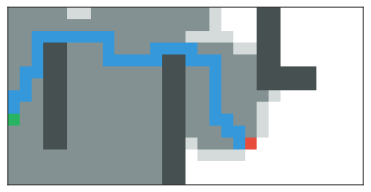

Path found! Length: 38. Search tree size: 308. Number of steps: 239. Correct: False


In [17]:
"""
Tests ## 0, 4, 8, 12, 14, 17, 18 should return incorrect result
"""
res = simple_test(astar, 0, inconsistent_heuristic, SearchTreePQD)

## A* Algorithm With Reexpansion

Let's enhance our `A*` implementation by adding the ability to re-open and re-expand nodes. After this modification, we'll verify that everything operates correctly.


In [18]:
class SearchTreePQDReexp:
    """
    Search Tree with re-expansion capability.
    Uses a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for the OPEN nodes

        # We use a dictionary for CLOSED as we want to access the g-value of a node.
        # A set() doesn't provide this capability.
        self._closed = {}  # Dictionary for nodes that have been expanded (CLOSED).
        self._reexpanded = set()  # Nodes that were expanded more than once
        self._reopened = set()  # Nodes that were moved from CLOSED to OPEN
        self._enc_open_duplicates = 0  # Count of duplicates encountered in OPEN
        self._number_of_reexpansions = 0  # Count of re-expansions

    def __len__(self):
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self):
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return not self._open

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree (specifically to OPEN). The node can be:
        (1) Completely new (never encountered before).
        (2) A duplicate of a node that currently resides in OPEN.
        (3) A better version (with a lower g-value) of a node that is already in CLOSED.

        The handling of the first two cases involves simply adding the node to OPEN.
        duplicates in OPEN will be detected lazily when retrieving the best node from OPEN.

        For the third case, the node with the higher g-value is removed from CLOSED
        before the new node is added to OPEN. Additionally, for illustrative purposes,
        the new node is added to REOPENED to keep track of such nodes.
        """
        if item in self._closed:
            if self._closed[item].g > item.g:
                self._closed.pop(item)
                self._reopened.add(item)
            else:
                return

        # Here, we ONLY add the node and never check whether a node with the same (i,j) already resides in the priority queue (PQ).
        # This approach can lead to occasional duplicates.
        # We will check for these duplicates lazily when invoking the get_best_node method.
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """

        """
        Extracting the best node (i.e. the one with the minimal key) from OPEN.
        This node will be expanded further on in the main loop of the search.
        
        Here we must take care of the OPEN-duplicates and discard the
        node if it resides in CLOSED and take the next node.
        And repeat this process until we encouter the node that is not in CLOSED currently.
        If no such a node left in OPEN, we return None.
        
        If a valid node is encountered, we need to check if it resides in REOPENED.
        If it does, we add it to REEXPANDED and increment the counter for the re-expanded nodes. 
        This step is included for illustrative purposes only.
        """
        while self._open:
            node = heappop(self._open)
            if not self.was_expanded(node):
                if node in self._reopened:
                    self._reexpanded.add(node)
                    self._number_of_reexpansions += 1
                return node
            else:
                self._enc_open_duplicates += 1
        return None
        

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

    @property
    def reexpanded(self):
        return self._reexpanded

    @property
    def number_of_reexpansions(self):
        return self._number_of_reexpansions

The input for the `A*` algorithm with re-expansions implementation is the same as for `Dijkstra`:

The input is:
- map representation
- start/goal cells
- heuristic function $^*$
- a reference to the implementation of the SearchTree

The output is:
- path found flag (`true` or `false`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)
- OPEN and CLOSED (as iterable collections of nodes) for further visualization purposes
- REEXPANDED (as iterable collections of nodes) for further visualization purposes


PS: You might also want to display, at the final iteration, the number of OPEN duplicates encountered during the search, as shown below:

```python
print("During the search, the following number of OPEN duplicates was encountered: ", ast.number_of_open_duplicates) 
print("During the search, the following number of reexpanded nodes was encountered ", ast.number_of_reexpansions)
```


In [19]:
def astar_reexpansion(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQDReexp],
) -> Tuple[
    bool,
    Optional[Node],
    int,
    int,
    Optional[Iterable[Node]],
    Optional[Iterable[Node]],
    Optional[Iterable[Node]],
]:
    """
    Implementation of A* algorithm with node reexpansion.
    """
    def get_heuristic(node_i, node_j):
        return heuristic_func(node_i, node_j, goal_i, goal_j)

    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=get_heuristic(start_i, start_j))
    goal_node = Node(goal_i, goal_j)
    
    ast.add_to_open(start_node)

    while node := ast.get_best_node_from_open():
        steps += 1
        ast.add_to_closed(node)
        if node == goal_node:
            print("During the search, the following number of OPEN duplicates was encountered: ", ast.number_of_open_duplicates)
            print("During the search, the following number of reexpanded nodes was encountered ", ast.number_of_reexpansions)
            return True, node, steps, len(ast), ast.opened, ast.expanded, ast.reexpanded
        for i, j in task_map.get_neighbors(node.i, node.j):
            neighbor = Node(i, j, g=node.g + compute_cost(node.i, node.j, i, j),
                            h=get_heuristic(i, j), parent=node)
            ast.add_to_open(neighbor)

    print("During the search, the following number of OPEN duplicates was encountered: ", ast.number_of_open_duplicates)
    print("During the search, the following number of reexpanded nodes was encountered ", ast.number_of_reexpansions)
    return False, None, steps, len(ast), ast.opened, ast.expanded, ast.reexpanded

## Tests with Inconsistent Heuristic Function

A* results:
During the search, the following number of OPEN duplicates was encountered:  227


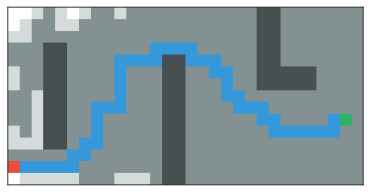

Path found! Length: 46. Search tree size: 448. Number of steps: 358. Correct: False

A* reexp. results:
During the search, the following number of OPEN duplicates was encountered:  311
During the search, the following number of reexpanded nodes was encountered  66


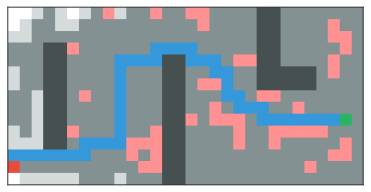

Path found! Length: 44. Search tree size: 460. Number of steps: 426. Correct: True


In [20]:
"""
Let's now try some tests that previously produced incorrect paths.

Test numbers: 0, 4, 8, 12, 14, 17, 18.

Now, everything should work correctly, and we should be able to see the re-expanded nodes in a shade of red.
"""

i = 18
print("A* results:")
res = simple_test(astar, i, inconsistent_heuristic, SearchTreePQD)

print()

print("A* reexp. results:")
res = simple_test(astar_reexpansion, i, inconsistent_heuristic, SearchTreePQDReexp)

## A* and Tie-breakers

The influence of tie-breaking criteria can significantly affect the performance of A*.

Let's implement two different secondary criteria (when the f-value is the same, we'll consider the g-value) and see which one performs better.


In [21]:
def lt_g_max(self, other):
    if self.f == other.f:
        return self.g > other.g
    return self.f < other.f


def lt_g_min(self, other):
    if self.f == other.f:
        return self.g < other.g
    return self.f < other.f

G_MAX (= H-MIN) tie-breaker
During the search, the following number of OPEN duplicates was encountered:  0


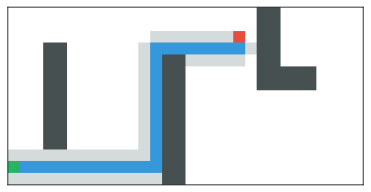

Path found! Length: 30. Search tree size: 79. Number of steps: 31. Correct: True
G_MIN (= H-MAX) tie-breaker
During the search, the following number of OPEN duplicates was encountered:  109


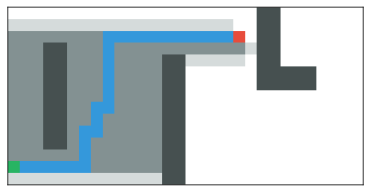

Path found! Length: 30. Search tree size: 191. Number of steps: 152. Correct: True


In [22]:
i = 1

print("G_MAX (= H-MIN) tie-breaker")
Node.__lt__ = lt_g_max
res1 = simple_test(astar, i, manhattan_distance, SearchTreePQD)

print("G_MIN (= H-MAX) tie-breaker")
Node.__lt__ = lt_g_min
res2 = simple_test(astar, i, manhattan_distance, SearchTreePQD)

## Run Massive Tests

<center><img src="./img/2.png"/></center>

In [23]:
Node.__lt__ = lt_g_max
%time g_max_results = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQD)

During the search, the following number of OPEN duplicates was encountered:  0
Task: #0. Path found! Length: 64. Search tree size: 179. Number of steps: 65. Correct: True
During the search, the following number of OPEN duplicates was encountered:  2835
Task: #1. Path found! Length: 197. Search tree size: 3552. Number of steps: 3341. Correct: True
During the search, the following number of OPEN duplicates was encountered:  0
Task: #2. Path found! Length: 462. Search tree size: 4570. Number of steps: 2164. Correct: True
During the search, the following number of OPEN duplicates was encountered:  24650
Task: #3. Path found! Length: 498. Search tree size: 27630. Number of steps: 27047. Correct: True
During the search, the following number of OPEN duplicates was encountered:  20837
Task: #4. Path found! Length: 479. Search tree size: 25037. Number of steps: 23455. Correct: True
During the search, the following number of OPEN duplicates was encountered:  664
Task: #5. Path found! Length: 402

In [24]:
Node.__lt__ = lt_g_min
%time g_min_results = massive_test(astar, "data/", 9, manhattan_distance, SearchTreePQD)

During the search, the following number of OPEN duplicates was encountered:  913
Task: #0. Path found! Length: 64. Search tree size: 1138. Number of steps: 1017. Correct: True
During the search, the following number of OPEN duplicates was encountered:  3244
Task: #1. Path found! Length: 197. Search tree size: 3895. Number of steps: 3734. Correct: True
During the search, the following number of OPEN duplicates was encountered:  20189
Task: #2. Path found! Length: 462. Search tree size: 22145. Number of steps: 21282. Correct: True
During the search, the following number of OPEN duplicates was encountered:  25086
Task: #3. Path found! Length: 498. Search tree size: 27817. Number of steps: 27371. Correct: True
During the search, the following number of OPEN duplicates was encountered:  22397
Task: #4. Path found! Length: 479. Search tree size: 25039. Number of steps: 24290. Correct: True
During the search, the following number of OPEN duplicates was encountered:  10565
Task: #5. Path found

In [25]:
g_min_steps = np.array(g_min_results["steps"]).mean()
g_max_steps = np.array(g_max_results["steps"]).mean()
g_min_st_size = np.array(g_min_results["st_size"]).mean()
g_max_st_size = np.array(g_max_results["st_size"]).mean()
print(f"{g_min_steps:.4f}, {g_max_steps:.4f}")
print(f"{g_min_st_size:.4f}, {g_max_st_size:.4f}")

29638.6667, 23401.4444
30265.3333, 27675.7778


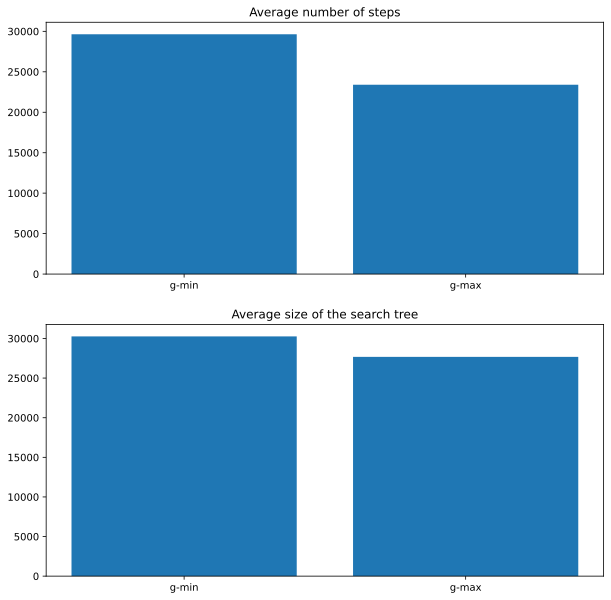

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].set_title("Average number of steps")
ax[1].set_title("Average size of the search tree")
ax[0].bar(["g-min", "g-max"], [g_min_steps, g_max_steps])
ax[1].bar(["g-min", "g-max"], [g_min_st_size, g_max_st_size]);